In [1]:
import os
from deep_dating.datasets import DatasetName, DatingDataLoader, SetType, CrossVal, CLaMM, MPS
from deep_dating.networks import DatingCNN, DatingTrainer, Autoencoder
from deep_dating.util import DATASETS_PATH
from deep_dating.prediction import DatingPredictor
from preprocessing import preprocess_autoencoder, preprocess_dating_cnn
from sklearn.manifold import TSNE
from deep_dating.metrics import DatingMetrics
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import os 
import shutil
from deep_dating.util import DATASETS_PATH
import cv2
import pickle
from deep_dating.preprocessing import PreprocessRunner
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
import keras
from keras import layers
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

Seed set to 43


2024-02-18 17:38:24.732222: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-18 17:38:24.732262: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-18 17:38:24.733590: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-18 17:38:24.740730: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-18 17:38:25.906113: W tensorflow/compiler/tf2

In [4]:
clamm = CLaMM()

In [2]:
run_path =  "runs/auto_true/" #"runs/Jan8-19-25-16/" #"runs/Jan6-22-21-16/" #"runs/Dec21-16-31-47"
model_name = "model_epoch_196"
all_labels_, all_outputs_, all_paths_ = DatingPredictor().load(os.path.join(run_path, model_name + "_feats_train.pkl"))
all_labels_val_, all_outputs_val_, all_paths_val_ = DatingPredictor().load(os.path.join(run_path, model_name + "_feats_val.pkl"))

In [3]:
all_labels = all_labels_.flatten()
print(all_labels)
all_labels_val = all_labels_val_.flatten()
print(all_labels_val)

[1150. 1488. 1488. ... 1000. 1150. 1463.]
[1000. 1000. 1000. ... 1463. 1275. 1463.]


In [23]:
labels = np.unique(all_labels_)
labels

array([1000., 1050., 1150., 1225., 1275., 1325., 1375., 1413., 1438.,
       1463., 1488., 1513., 1538., 1563., 1588.], dtype=float32)

In [44]:
all_outputs_.shape

tsne = TSNE(n_components=2)
#tsne = PCA(n_components=2)
features_tsne_2d = tsne.fit_transform(all_outputs_)

In [30]:
def get_scripts(paths):
    scripts = []

    for x_ in paths:
        x = PreprocessRunner.get_base_img_name(x_).split("__")[0].split("_aug")[0] + ".tif"
        row = clamm.header_df[clamm.header_df["FILENAME"] == x]["SCRIPT_TYPE"].to_list()
        scripts.append(row)

    return np.array(scripts)

scripts_train = get_scripts(all_paths_)
scripts_val = get_scripts(all_paths_val_)

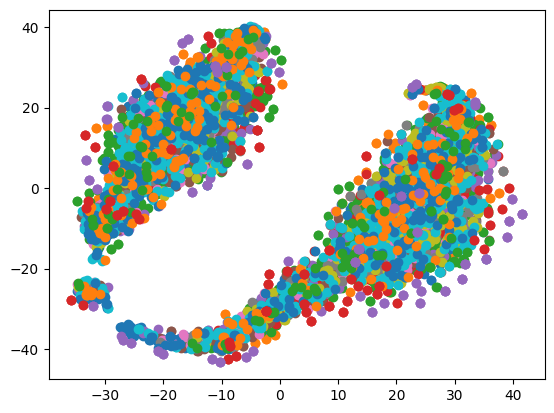

In [48]:
for l in np.unique(all_labels_):
    idxs = np.where(all_labels_ == l)[0]
    plt.scatter(features_tsne_2d[idxs, 0], features_tsne_2d[idxs, 1])
plt.show()

In [67]:
# kmeans = KMeans(n_clusters=2, random_state=42, n_init="auto").fit(all_outputs_)
# kmeans.labels_
# # os.mkdir("group_0")
# # os.mkdir("group_1")

# paths = np.array(all_paths_)
# svms = []

# for i in range(2):
#     idxs = np.where(kmeans.labels_ == i)[0]

#     pca = PCA(n_components=2)
#     pca_val = pca.fit_transform(all_outputs_[idxs, :])

#     for l in np.unique(all_labels_[idxs]):
#         j = np.where(all_labels_[idxs] == l)[0]

#         plt.scatter(pca_val[j, 0], pca_val[j, 1])

#     plt.show()

#     svm = SVC()
#     svm.fit(all_outputs_[idxs, :], all_labels_[idxs].ravel())
#     svms.append(svm)

clusters = kmeans.predict(all_outputs_val_)
for i in range(2):
    idxs = np.where(clusters == i)[0]

    val_predict_labels = svms[i].predict(all_outputs_val_[idxs, :])
    print(accuracy_score(all_labels_val[idxs].ravel(), val_predict_labels))

0.39290586630286495
0.26584234930448225


In [62]:
def get_feat(labels, outputs, paths):
    preds = {}

    for i, img_name in enumerate(paths):
        img_name = PreprocessRunner.get_base_img_name(img_name)
        if not img_name in preds:
            preds[img_name] = [labels[i], [outputs[i]]]
        else:
            preds[img_name][1].append(outputs[i])

    features = []
    labels_new = []
    print(preds.keys())
    for key, val in preds.items():
        preds[key][1] = np.mean(preds[key][1], axis=0)
        
        features.append(preds[key][1])
        labels_new.append(preds[key][0])

    features = np.array(features)
    return features, np.array(labels_new), preds

train_feat, train_labels, train_feat_preds = get_feat(all_labels, all_outputs_, all_paths_)
val_feat, val_labels, val_feat_preds = get_feat(all_labels_val, all_outputs_val_, all_paths_val_)

dict_keys(['IRHT_P_001199__505_1150', 'IRHT_P_009138__2188_1488', 'IRHT_P_002523__2179_1488', 'IRHT_P_001700__630_1150', 'IRHT_P_005060__894_1225', 'IRHT_P_004869__2421_1513', 'IRHT_P_002510__233_1000', 'IRHT_P_000522__1807_1463', 'IRHT_P_008843__1952_1463', 'IRHT_P_005459__1834_1463', 'btv1b105162865_f82__2329_1513', 'IRHT_P_005048__1397_1375', 'IRHT_P_001288__1869_1463', 'IRHT_P_000498__1305_1375', 'IRHT_P_002635__556_1150', 'IRHT_P_000584_aug_4__2642_1588', 'IRHT_P_004571__762_1150', 'IRHT_P_002022__59_1000', 'IRHT_P_009259__2619_1588', 'IRHT_P_002436__850_1225', 'IRHT_P_005007_aug_7__2524_1538', 'IRHT_P_000207__1955_1463', 'IRHT_P_003614__1383_1375', 'IRHT_P_001992__1916_1463', 'IRHT_P_000770__1159_1325', 'IRHT_P_002796__1271_1375', 'IRHT_P_000470__1534_1413', 'IRHT_P_009141_aug_22__2586_1563', 'IRHT_P_000981__2301_1488', 'IRHT_P_009223__1746_1463', 'IRHT_P_001232__1510_1413', 'IRHT_P_003654__1104_1325', 'IRHT_P_003407__2285_1488', 'IRHT_P_000095__1325_1375', 'IRHT_P_005924__1754_1

In [36]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_labels)
y_train = to_categorical(y_train)
y_val = label_encoder.transform(val_labels)
y_val = to_categorical(y_val)
print(y_train.shape)

model = keras.Sequential(
    [
        keras.Input(shape=(8192)),
        layers.Dense(4096, activation="relu"),
        layers.Dense(1024, activation="relu"),
        layers.Dense(512, activation="relu"),
        layers.Dense(15, activation="softmax"),
    ]
)
batch_size = 32
epochs = 100

model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])
model.fit(train_feat, y_train, batch_size=batch_size, epochs=epochs, validation_data=(val_feat, y_val))


(2693, 15)
Epoch 1/100
85/85 [==============================] - 27s 311ms/step - loss: 4.0478 - accuracy: 0.1537 - val_loss: 2.3797 - val_accuracy: 0.2669
Epoch 2/100
85/85 [==============================] - 26s 311ms/step - loss: 2.4416 - accuracy: 0.2154 - val_loss: 2.2198 - val_accuracy: 0.3051
Epoch 3/100
85/85 [==============================] - 26s 310ms/step - loss: 2.3885 - accuracy: 0.2339 - val_loss: 2.2160 - val_accuracy: 0.3093
Epoch 4/100
85/85 [==============================] - 26s 310ms/step - loss: 2.2911 - accuracy: 0.2536 - val_loss: 2.1564 - val_accuracy: 0.2938
Epoch 5/100
85/85 [==============================] - 26s 312ms/step - loss: 2.2672 - accuracy: 0.2685 - val_loss: 2.2009 - val_accuracy: 0.2994
Epoch 6/100
85/85 [==============================] - 26s 311ms/step - loss: 2.2317 - accuracy: 0.2726 - val_loss: 2.1497 - val_accuracy: 0.3347
Epoch 7/100
85/85 [==============================] - 26s 310ms/step - loss: 2.1514 - accuracy: 0.2885 - val_loss: 2.2065 - va

KeyboardInterrupt: 

In [35]:
train_feat.shape
train_labels.ravel().shape

(2693,)

In [63]:
svm = SVC()
svm.fit(train_feat, train_labels.ravel())

SVC()

In [68]:
val_predict_labels = svm.predict(val_feat)

alphas = [0, 25, 50, 75, 100]
metrics = DatingMetrics(alphas=alphas)
metrics.names

vals = metrics.calc(val_labels.ravel(), val_predict_labels)

mae, mse = tuple(vals[:2])
cs_ = vals[2:]
# print(cs_)

# plt.plot(alphas, cs_)
# plt.xlabel("Alpha Value")
# plt.ylabel("Cumulative Score")
# plt.ylim(0, 100)
# plt.xticks(np.arange(0, 55, 5))
# plt.axvline(x=25, color="red")
# plt.show()

print(mae, mse)
print(alphas)
print(cs_)

# 47.45140388768898 4557.235421166307
# [0, 25, 50, 75, 100]
# [31.01511879049676, 51.360691144708426, 67.34341252699784, 80.47516198704103, 89.8488120950324]

160.1271186440678 55182.71186440678
[0, 25, 50, 75, 100]
[32.20338983050847, 39.40677966101695, 45.76271186440678, 47.59887005649718, 51.69491525423729]


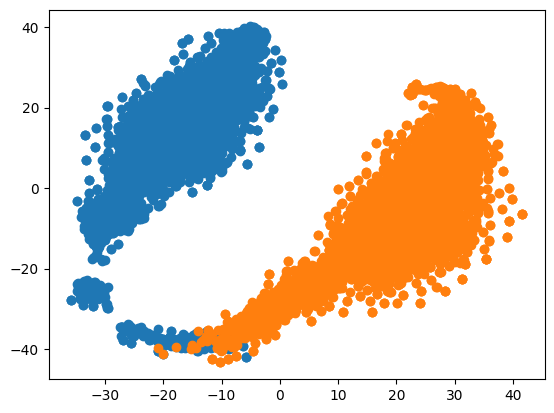

In [49]:
kmeans = KMeans(n_clusters=2, random_state=42, n_init="auto").fit(all_outputs_)
kmeans.labels_
# os.mkdir("group_0")
# os.mkdir("group_1")

paths = np.array(all_paths_)

for i in range(4):
    idxs = np.where(kmeans.labels_ == i)[0]
    # os.mkdir(f"group_{i}")
    # for path in paths[idxs]:
    #     img_name = os.path.basename(path)
    #     path = os.path.join(DATASETS_PATH, "CLAMM_Set_Auto", img_name)
    #     shutil.copy(path, os.path.join(f"group_{i}", img_name))

    plt.scatter(features_tsne_2d[idxs, 0], features_tsne_2d[idxs, 1])
plt.show()

In [11]:
import torch

model_path = "runs/auto_mps/model_epoch_24.pt" #"runs/Jan8-19-25-16/model_epoch_3.pt"

model = Autoencoder()
model.load(model_path, continue_training=True)

imgs = [os.path.join(DATASETS_PATH, "MPS_Set_Auto/MPS1500_0347__10_1500_p1.png")]

patches = [model.transform_img(x) for x in imgs]
patches = torch.from_numpy(np.array(patches))

output = model(patches)
output = output.cpu().detach().numpy()

RuntimeError: Error(s) in loading state_dict for Autoencoder:
	Missing key(s) in state_dict: "l1.weight", "l1.bias", "l2.weight", "l2.bias". 
	Unexpected key(s) in state_dict: "encoder.0.weight", "encoder.0.bias", "encoder.1.weight", "encoder.1.bias", "encoder.1.running_mean", "encoder.1.running_var", "encoder.1.num_batches_tracked", "encoder.3.weight", "encoder.3.bias", "encoder.4.weight", "encoder.4.bias", "encoder.4.running_mean", "encoder.4.running_var", "encoder.4.num_batches_tracked", "encoder.6.weight", "encoder.6.bias", "encoder.7.weight", "encoder.7.bias", "encoder.7.running_mean", "encoder.7.running_var", "encoder.7.num_batches_tracked", "encoder.9.weight", "encoder.9.bias", "encoder.10.weight", "encoder.10.bias", "encoder.10.running_mean", "encoder.10.running_var", "encoder.10.num_batches_tracked", "encoder.12.weight", "encoder.12.bias", "encoder.13.weight", "encoder.13.bias", "encoder.13.running_mean", "encoder.13.running_var", "encoder.13.num_batches_tracked", "encoder.16.weight", "encoder.16.bias", "decoder.0.weight", "decoder.0.bias", "decoder.3.weight", "decoder.3.bias", "decoder.4.weight", "decoder.4.bias", "decoder.4.running_mean", "decoder.4.running_var", "decoder.4.num_batches_tracked", "decoder.6.weight", "decoder.6.bias", "decoder.7.weight", "decoder.7.bias", "decoder.7.running_mean", "decoder.7.running_var", "decoder.7.num_batches_tracked", "decoder.9.weight", "decoder.9.bias", "decoder.10.weight", "decoder.10.bias", "decoder.10.running_mean", "decoder.10.running_var", "decoder.10.num_batches_tracked", "decoder.12.weight", "decoder.12.bias", "decoder.14.weight", "decoder.14.bias", "decoder.14.running_mean", "decoder.14.running_var", "decoder.14.num_batches_tracked", "decoder.15.weight", "decoder.15.bias". 

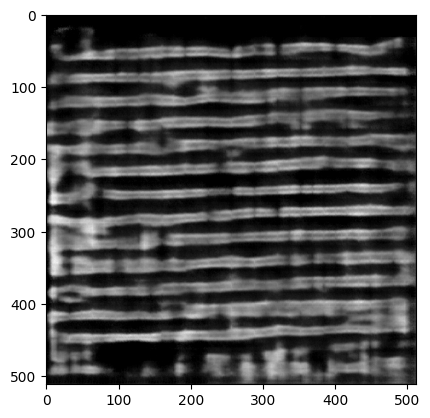

In [ ]:
plt.imshow(output[0, 0, :, :], cmap="gray")
plt.show()

In [10]:
def get_feat2(file_name="vgg19_feats_SetType.TRAIN"):
    with open(file_name, "rb") as f:
        all_labels, all_outputs, all_paths = pickle.load(f)

    #print(all_labels)
    # all_labels = np.concatenate(all_labels)
    # all_outputs = np.concatenate(all_outputs)
    

    preds = {}

    for i, img_name in enumerate(all_paths):
        img_name = PreprocessRunner.get_base_img_name(img_name)
        img_name = img_name.split("__")[0]
        if not img_name in preds:
            preds[img_name] = [all_labels[i], [all_outputs[i]]]
        else:
            preds[img_name][1].append(all_outputs[i])

    features = []
    labels = []
    for key, val in preds.items():
        preds[key][1] = np.mean(preds[key][1], axis=0)
        features.append(preds[key][1])
        labels.append(preds[key][0])
        # print(preds[key][1].shape)
        # exit()
    features = np.array(features)
    return features, np.array(labels), preds

train_x, train_y, train_preds = get_feat2("runs/Feb18-10-52-17/model_epoch_1_feats_train.pkl")
val_x, val_y, val_preds = get_feat2("runs/Feb18-10-52-17/model_epoch_1_feats_val.pkl")

In [13]:
print(train_x.shape, train_feat.shape, val_x.shape)

(1796, 1536) (1828, 512) (453, 1536)


In [11]:
def get_feat3(p, labels, outputs, paths):
    preds = {}

    l = [x.split("__")[0] for x in list(p.keys())]

    for i, img_name in enumerate(paths):
        img_name = PreprocessRunner.get_base_img_name(img_name)
        img_name = img_name.split("__")[0]
        if img_name.split("__")[0] not in l:
            continue
        if not img_name in preds:
            preds[img_name] = [labels[i], [outputs[i]]]
        else:
            preds[img_name][1].append(outputs[i])

    features = []
    labels_new = []
    print(preds.keys())
    print(p.keys())
    for key, val in p.items():
        preds[key][1] = np.mean(preds[key][1], axis=0)
        
        features.append(preds[key][1])
        labels_new.append(preds[key][0])

    features = np.array(features)
    return features, np.array(labels_new), preds

train_feat, train_labels, train_feat_preds = get_feat3(train_preds, all_labels, all_outputs_, all_paths_)
val_feat, val_labels, val_feat_preds = get_feat3(val_preds, all_labels_val, all_outputs_val_, all_paths_val_)

dict_keys(['IRHT_P_001199', 'IRHT_P_009138', 'IRHT_P_002523', 'IRHT_P_001700', 'IRHT_P_005060', 'IRHT_P_004869', 'IRHT_P_002510', 'IRHT_P_000522', 'IRHT_P_008843', 'IRHT_P_005459', 'btv1b105162865_f82', 'IRHT_P_005048', 'IRHT_P_001288', 'IRHT_P_000498', 'IRHT_P_002635', 'IRHT_P_000584_aug_4', 'IRHT_P_004571', 'IRHT_P_002022', 'IRHT_P_009259', 'IRHT_P_002436', 'IRHT_P_005007_aug_7', 'IRHT_P_000207', 'IRHT_P_003614', 'IRHT_P_001992', 'IRHT_P_000770', 'IRHT_P_002796', 'IRHT_P_000470', 'IRHT_P_009141_aug_22', 'IRHT_P_000981', 'IRHT_P_009223', 'IRHT_P_001232', 'IRHT_P_003654', 'IRHT_P_003407', 'IRHT_P_000095', 'IRHT_P_005924', 'IRHT_P_004798', 'IRHT_P_005175', 'IRHT_P_002109', 'IRHT_P_000174', 'IRHT_P_002319', 'IRHT_P_002085', 'IRHT_P_005644', 'btv1b10511002k_f53', 'IRHT_P_005008_aug_38', 'IRHT_P_000914', 'IRHT_P_002177', 'IRHT_P_000042', 'IRHT_P_004827_aug_26', 'btv1b8452656h_f66_1', 'IRHT_P_008541', 'IRHT_P_005469', 'IRHT_P_000876', 'IRHT_P_000281', 'IRHT_P_008632', 'IRHT_P_003432', 'IRHT

In [12]:
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier

scaler = StandardScaler()

In [13]:
new_train_x = np.hstack([train_feat, train_x])
print(new_train_x.shape)
new_train_x_scaled = scaler.fit_transform(new_train_x)

new_val_x = np.hstack([val_feat, val_x])
new_val_x_scaled = scaler.transform(new_val_x)

(2693, 9728)


In [14]:
c = SVC() #DummyClassifier(strategy="uniform")
c.fit(new_train_x_scaled, train_labels)
val_predict_labels = c.predict(new_val_x_scaled)

alphas = [0, 25, 50, 75]
metrics = DatingMetrics(alphas=alphas)
metrics.names

vals = metrics.calc(val_labels, val_predict_labels)

mae, mse = tuple(vals[:2])
cs_ = vals[2:]

print(mae, mse)
print(alphas)
print(cs_)

# 7.50551876379691 350.4415011037528
# [0, 25, 50, 75, 100]
# [78.80794701986756, 94.48123620309052, 97.57174392935983, 99.11699779249447, 100.0]

# 47.737306843267106 4443.9845474613685
# [0, 25, 50, 75, 100]
# [26.71081677704194, 50.77262693156733, 70.6401766004415, 80.79470198675497, 89.1832229580574]

36.46468926553672 6815.848870056498
[0, 25, 50, 75]
[56.355932203389834, 69.91525423728814, 82.48587570621469, 85.16949152542372]
